In [1]:
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import glob
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import random

from kerastuner import HyperModel, Hyperband

C:\Users\jblee\AppData\Local\Temp/ipykernel_14536/671448046.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


In [2]:
tf.random.set_seed(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# zip파일 경로 설정
data_zip_dir = 'D:/worksapce/DAT/'
train_zip_dir = 'D:/worksapce/DAT/' + 'train.zip'
test_zip_dir  = 'D:/worksapce/DAT/' + 'test.zip'

### 데이터 폴더 생성

In [4]:
train_dir = data_zip_dir + 'train'
test_dir = data_zip_dir + 'test1'

In [5]:
if os.path.isdir(train_dir) :
    shutil.rmtree(train_dir)
    
if os.path.isdir(test_dir) :
    shutil.rmtree(test_dir)

if os.path.isdir(data_zip_dir + 'cnn') :
    shutil.rmtree(data_zip_dir + 'cnn')    

In [6]:
# 압축해제
with zipfile.ZipFile(train_zip_dir, 'r') as z:
    z.extractall(data_zip_dir)
with zipfile.ZipFile(test_zip_dir, 'r') as z:
    z.extractall(data_zip_dir)

In [7]:
# train set 생성
train_cat_dir = data_zip_dir + 'cnn/train_set/' + "cat"
train_dog_dir = data_zip_dir + 'cnn/train_set/' + "dog"

os.makedirs(train_cat_dir, exist_ok=True)
os.makedirs(train_dog_dir, exist_ok=True)

# valid set 생성
valid_cat_dir = data_zip_dir + 'cnn/valid_set/' + "cat"
valid_dog_dir = data_zip_dir + 'cnn/valid_set/' + "dog"

os.makedirs(valid_cat_dir, exist_ok=True)
os.makedirs(valid_dog_dir, exist_ok=True)

# test set 생성
test_cat_dir = data_zip_dir + 'cnn/test_set/' + "cat"
test_dog_dir = data_zip_dir + 'cnn/test_set/' + "dog"

os.makedirs(test_cat_dir, exist_ok=True)
os.makedirs(test_dog_dir, exist_ok=True)

In [8]:
train_cat_file_names = [s for s in os.listdir(train_dir) if 'cat' in s]
train_dog_file_names = [s for s in os.listdir(train_dir) if 'dog' in s]

test_cat_file_names = [s for s in os.listdir(test_dir) if 'cat' in s]
test_dog_file_names = [s for s in os.listdir(test_dir) if 'dog' in s]

In [9]:
# train set 옮기기
for i in [str(s) + '.jpg' for s in range(2000)] :
    
    src_cat = train_dir + '/cat.' + i
    dst_cat = train_cat_dir + '/cat.' + i
    
    src_dog = train_dir + '/dog.' + i
    dst_dog = train_dog_dir + '/dog.' + i
    
    shutil.move(src_cat, dst_cat)
    shutil.move(src_dog, dst_dog)

# valid set 옮기기
for i in [str(s) + '.jpg' for s in range(2000,2100)] :
    
    src_cat = train_dir + '/cat.' + i
    dst_cat = valid_cat_dir + '/cat.' + i
    
    src_dog = train_dir + '/dog.' + i
    dst_dog = valid_dog_dir + '/dog.' + i
    
    shutil.move(src_cat, dst_cat)
    shutil.move(src_dog, dst_dog)

# test set 옮기기
for i in [str(s) + '.jpg' for s in range(2100,2200)] :
    
    src_cat = train_dir + '/cat.' + i
    dst_cat = test_cat_dir + '/cat.' + i
    
    src_dog = train_dir + '/dog.' + i
    dst_dog = test_dog_dir + '/dog.' + i
    
    shutil.move(src_cat, dst_cat)
    shutil.move(src_dog, dst_dog)



### 데이터 불러오기

In [10]:
# 데이터 불러오기
category = ['cat','dog']

# =======================
# train
# =======================
training_data = list()
for ctgry_ind in category:
    
    ctgry_ind_dir_root = 'D:/worksapce/DAT/cnn/train_set/' + ctgry_ind
    class_num = category.index(ctgry_ind)

    for img in os.listdir(ctgry_ind_dir_root) :
        img_array = cv2.imread(ctgry_ind_dir_root+ '/' + img)
        new_array = cv2.resize(img_array, (65, 65))
        training_data.append([new_array, class_num])

random.seed(1234)
random.shuffle(training_data)

TRAIN_X = []
TRAIN_Y = []

for features, label in training_data:
    TRAIN_X.append(features)
    TRAIN_Y.append(label)    

TRAIN_X = np.array(TRAIN_X).reshape(len(TRAIN_X), 65, 65 ,3)
TRAIN_Y = np.array(TRAIN_Y)



# =======================
# valid
# =======================
valid_data = list()
for ctgry_ind in category:
    
    ctgry_ind_dir_root = 'D:/worksapce/DAT/cnn/valid_set/' + ctgry_ind
    class_num = category.index(ctgry_ind)

    for img in os.listdir(ctgry_ind_dir_root) :
        img_array = cv2.imread(ctgry_ind_dir_root+ '/' + img)
        new_array = cv2.resize(img_array, (65, 65))
        valid_data.append([new_array, class_num])

random.seed(1234)
random.shuffle(valid_data)

VALID_X = []
VALID_Y = []

for features, label in valid_data:
    VALID_X.append(features)
    VALID_Y.append(label)    

VALID_X = np.array(VALID_X).reshape(len(VALID_X), 65, 65 ,3)
VALID_Y = np.array(VALID_Y)


# =======================
# test
# =======================
test_data = list()
for ctgry_ind in category:
    
    ctgry_ind_dir_root = 'D:/worksapce/DAT/cnn/test_set/' + ctgry_ind
    class_num = category.index(ctgry_ind)

    for img in os.listdir(ctgry_ind_dir_root) :
        img_array = cv2.imread(ctgry_ind_dir_root+ '/' + img)
        new_array = cv2.resize(img_array, (65, 65))
        test_data.append([new_array, class_num])

random.seed(1234)
random.shuffle(test_data)

TEST_X = []
TEST_Y = []

for features, label in test_data:
    TEST_X.append(features)
    TEST_Y.append(label)    

TEST_X = np.array(TEST_X).reshape(len(TEST_X), 65, 65 ,3)
TEST_Y = np.array(TEST_Y)

In [11]:
# scailing
TRAIN_X = tf.convert_to_tensor(TRAIN_X, dtype=tf.float32) / 255.
VALID_X = tf.convert_to_tensor(VALID_X, dtype=tf.float32) / 255.
TEST_X = tf.convert_to_tensor(TEST_X, dtype=tf.float32) / 255.

### CNN Hyper Model Class 생성

In [12]:
# =========================================
# CNN HyperModel Class
# =========================================

class CNN_Model(HyperModel) :
    
    def __init__ (self, Shape):
        self.Shape = Shape

    def build(self, hp):
        
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(32, kernel_size = hp.Choice('kernel_0', values = [3, 5])
                                         , padding='same'
                                         , input_shape = self.Shape))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        for i,conv_filter in zip([1,2],[64,128]):
            model.add(tf.keras.layers.Conv2D(conv_filter, kernel_size = hp.Choice('kernel_{}'.format(i), values = [3, 5])
                                             , padding='same'))
            #model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Activation('relu'))
            model.add(tf.keras.layers.MaxPooling2D(pool_size= hp.Choice('maxpool_{}'.format(i), values = [2])))

        model.add(tf.keras.layers.Flatten())

        for dense in [128,64]:
            model.add(tf.keras.layers.Dense(dense, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(hp.Choice('dropout', values = [0.1,0.5])))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer=tf.keras.optimizers.Adadelta(1e-3),loss='binary_crossentropy',metrics='acc')
        
        return model

In [13]:
# ============================================
# CnnHyperband : batch_size 튜닝 추가
# ============================================
class CnnHyperband(Hyperband):
    """
    Hyperband 서브 클래스
    """
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values = [2**x for x in range(2,3)])
        return super().run_trial(trial,*args,**kwargs)

In [14]:
class CNN_TRAIN(object):
    
    def __init__ (self, Train_CNN_y, Train_CNN_x, Valid_CNN_y, Valid_CNN_x, Shape, Patience , epochs, model_num):
        
        self.Train_CNN_y = Train_CNN_y
        self.Train_CNN_x = Train_CNN_x
        self.Valid_CNN_y = Valid_CNN_y
        self.Valid_CNN_x = Valid_CNN_x
        self.Shape       = Shape
        self.Patience    = Patience
        self.epochs      = epochs
        self.model_num   = model_num
        self.cnn_train()
                
    def cnn_train(self):
        
        # 폴더 삭제
        shutil.rmtree('D:/workspace/OUT/best_model_cnn/best_model_cnn_{}.h5'.format(self.model_num),ignore_errors=True)
        shutil.rmtree('D:/worksapce/OUT/hyper_model_cnn/'+'cnn_{}'.format(self.model_num),ignore_errors=True)
        
        # Hyperband tuner setting
        tuner = CnnHyperband(CNN_Model(self.Shape),
                             objective = 'val_loss', 
                             max_epochs = 5,
                             factor = 3,
                             directory = 'D:/worksapce/OUT/hyper_model_cnn',
                             project_name = 'cnn_{}'.format(self.model_num),
                             overwrite = True)
        

        # tuner Serach
        tuner.search(self.Train_CNN_x, self.Train_CNN_y, epochs = self.epochs
                     , validation_data = (self.Valid_CNN_x, self.Valid_CNN_y)
                     , verbose = 2)

        # Get the optimal hyperparameters
        self.best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
        
        # Build the model with the optimal hyperparameters and train it on the data
        self.cnn_model = tuner.hypermodel.build(self.best_hps)
        
        # Early Stopping 
        """
        - restore_best_weights -
        Whether to restore model weights from the epoch with the best value of the monitored quantity.
        If False, the model weights obtained at the last step of training are used
        """
        EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = self.Patience,
                                                         restore_best_weights=True, verbose = 1) 
        
        # reduce_lr
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=0, mode='min', min_lr=1e-5)
        
        # 모델 저장
        ModelCheck = tf.keras.callbacks.ModelCheckpoint(filepath = 'D:/workspace/OUT/best_model_cnn/best_model_cnn_{}.h5'.format(self.model_num)
                                                        , monitor = 'val_loss'
                                                        , mode = 'min'
                                                        , save_best_only = True)
        # History
        history = tf.keras.callbacks.History()
        
        # 에폭 10까지 학습
        self.cnn_model.fit(self.Train_CNN_x, self.Train_CNN_y, epochs = 10, validation_data=(self.Valid_CNN_x, self.Valid_CNN_y)
                      , batch_size = self.best_hps['batch_size']
                      , verbose=0
                      , callbacks = [history])
        
        
        # 에폭 10부터 학습
        self.cnn_model.fit(self.Train_CNN_x, self.Train_CNN_y
                      , validation_data=(self.Valid_CNN_x, self.Valid_CNN_y)     
                      , initial_epoch = 10
                      , epochs = self.epochs
                      , batch_size = self.best_hps['batch_size']     
                      , callbacks = [EarlyStopping, reduce_lr, ModelCheck, history]
                      , verbose=0)
        
        return self.cnn_model
        


### CNN 학습

In [15]:
# ============================================
# 모델 구조별 Fit
# ============================================

Shape = (65,65,3)
mdl_num = 1

# get model
cnn_mdl = CNN_TRAIN(TRAIN_Y, TRAIN_X, VALID_Y, VALID_X,Shape, 30 , 100, mdl_num)

# get bset epoch & valid loss
best_epoch = np.argmin(cnn_mdl.cnn_model.history.history['val_loss'][10:]) + 11
vaild_loss = np.min(cnn_mdl.cnn_model.history.history['val_loss'][10:])

# best_hps
cnn_mdl.best_hps.values

Trial 10 Complete [00h 00m 54s]
val_loss: 0.6702033281326294

Best val_loss So Far: 0.6702033281326294
Total elapsed time: 00h 04m 52s
INFO:tensorflow:Oracle triggered exit


{'kernel_0': 5,
 'kernel_1': 5,
 'maxpool_1': 2,
 'kernel_2': 5,
 'maxpool_2': 2,
 'dropout': 0.1,
 'batch_size': 4,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

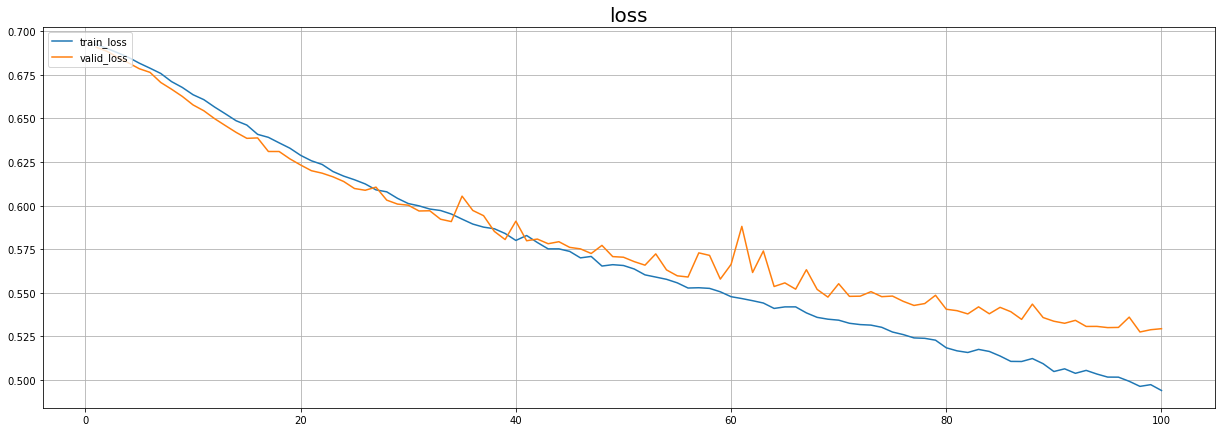

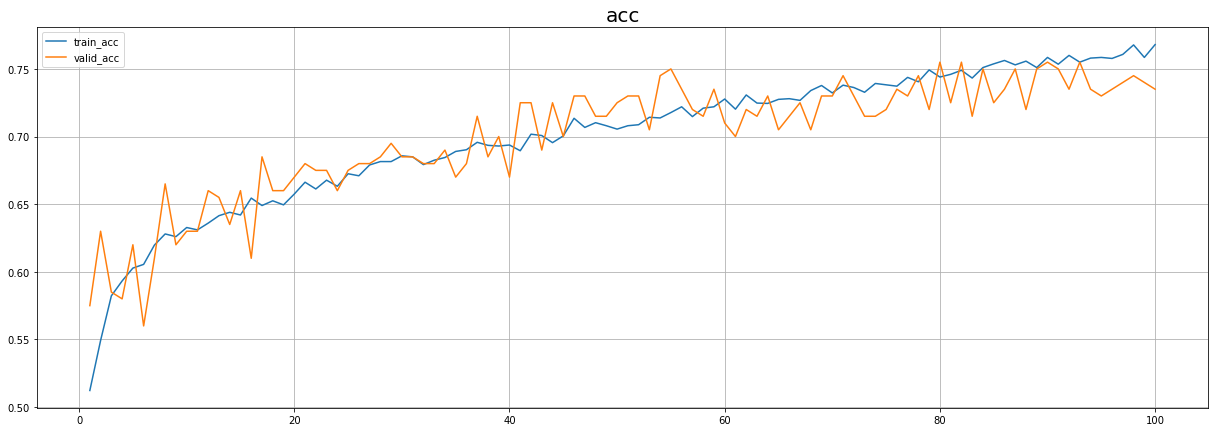

In [16]:
# ============================================
# LOSS, ACCURACY 그래프
# ============================================

plt.figure(figsize = (21,7))
plt.title('loss' , fontsize = 20)
plt.plot(range(1,len(cnn_mdl.cnn_model.history.history['loss'])+1), cnn_mdl.cnn_model.history.history['loss'], label = 'train_loss')
plt.plot(range(1,len(cnn_mdl.cnn_model.history.history['loss'])+1), cnn_mdl.cnn_model.history.history['val_loss'], label = 'valid_loss')
plt.grid(True)
plt.legend(loc = 'upper left')

plt.figure(figsize = (21,7))
plt.title('acc', fontsize = 20)
plt.plot(range(1,len(cnn_mdl.cnn_model.history.history['loss'])+1), cnn_mdl.cnn_model.history.history['acc'], label = 'train_acc')
plt.plot(range(1,len(cnn_mdl.cnn_model.history.history['loss'])+1), cnn_mdl.cnn_model.history.history['val_acc'], label = 'valid_acc')
plt.grid(True)
plt.legend(loc = 'upper left')

### Feature Map 추출

In [17]:
# feature map 추출
feature_map_model = tf.keras.Model(inputs = cnn_mdl.cnn_model.inputs
                                 , outputs = cnn_mdl.cnn_model.layers[len(cnn_mdl.cnn_model.layers)-2].output)

train_feature_map = feature_map_model.predict(TRAIN_X, batch_size = 4)
valid_feature_map = feature_map_model.predict(VALID_X, batch_size = 4)

### 예측

In [18]:
test_pred_y = cnn_mdl.cnn_model.predict(TEST_X,batch_size=4)[:,0]
tf.keras.metrics.binary_accuracy(TEST_Y, test_pred_y, threshold=0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.745>

In [19]:
test_pred_y = np.where(test_pred_y >= 0.5,1,0)
tab = pd.crosstab(TEST_Y,test_pred_y, rownames = ['True'], colnames = ['Pred'])

acc = (tab.iloc[0,0] + tab.iloc[1,1])/tab.sum().sum()
sen = (tab.iloc[1,1])/tab.iloc[1,].sum()
spc = (tab.iloc[0,0])/tab.iloc[0,].sum()

print('Accuracy    :', acc)
print('Sensitivity :', sen)
print('Specificity :', spc)

Accuracy    : 0.745
Sensitivity : 0.77
Specificity : 0.72
